# Hyperparameter Optimization of CNN Using Optuna

Optuna will be used to optimize the hyperparameters of a CNN using Optuna, which is an open-source hyperparameter optimzation package.

In [7]:
import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# see: # https://www.tensorflow.org/api_docs/python/tf/random/set_seed 
tf.random.set_seed(1234)

## Import packages

In [8]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop

import optuna

##  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [9]:
# Load the data
#data = pd.read_csv('/content/drive/MyDrive/datasets/mnist.csv') 

data = pd.read_csv('mnist.csv') 
# first column is the target, the rest of the columns are the pixels of the image
# each row is 1 image

data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

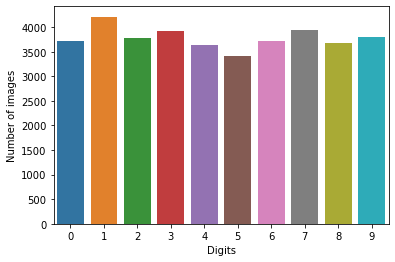

In [11]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [12]:
# Re-scale the data. 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 28 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [13]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [14]:
# the target is 1 variable with the 10 different digits as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [15]:
# For Keras, we need to create 10 dummy variables, one for each digit
# The labels are one-hot encoded. 

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Print some example images.

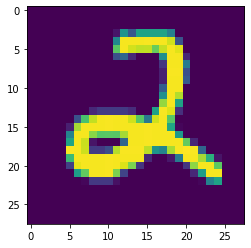

In [16]:
# Some image examples 
g = plt.imshow(X_train[0][:,:,0])

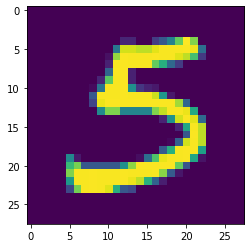

In [17]:
# Some image examples 
g = plt.imshow(X_train[10][:,:,0])

## Define-by-run design

We create the CNN and add the sampling space for the hyperparameters as we go. This is the define-by-run concept.

In [18]:
# Save the model with this name
path_best_model = 'cnn_model_2.h5'

# starting point for the optimization
best_accuracy = 0

In [19]:
# function to create the CNN

def objective(trial):

    # Construct a Keras Sequential model.
    model = Sequential()

    # Convolutional layers.

    # Add the different number of conv layers in the following loop:
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):
        
        # Note, with this configuration, we sample different filters, kernels
        # stride etc, for each convolutional layer that we add

        model.add(Conv2D(
            filters=trial.suggest_categorical('filters_{}'.format(i), [16, 32, 64]),
            kernel_size=trial.suggest_categorical('kernel_size{}'.format(i), [3, 5]),
            strides=trial.suggest_categorical('strides{}'.format(i), [1, 2]),
            activation=trial.suggest_categorical('activation{}'.format(i), ['relu', 'tanh']),
            padding='same',
        ))

    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers. 
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):

        # Add the dense fully-connected layer to the model.
        # This has two hyperparameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(
            units=trial.suggest_int('units{}'.format(i), 5, 512),
            activation=trial.suggest_categorical('activation{}'.format(i), ['relu', 'tanh']),
            ))

    # Last fully-connected dense layer with softmax-activation for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer_name = trial.suggest_categorical('optimizer_name', ['Adam', 'RMSprop'])

    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = RMSprop(
            learning_rate=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable" time. 
    # If we increase the epochs, we will have better performance this could be another parameter to optimize in fact.
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        batch_size=128,
        validation_split=0.1,
    )

    # Get the classification accuracy on the validation-set after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train the network with the best found parameters. 
        # We save it instead as we search for the best hyperparameter space.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyperparameters from memory.
    del model

    return accuracy

In [20]:
# we can store the search

study_name = "cnn_study_2"  # unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

In [21]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

study.optimize(objective, n_trials=30)

[I 2021-10-01 10:49:50,580] A new study created in RDB with name: cnn_study_2


Epoch 1/3
266/266 [==============================] - 64s 239ms/step - loss: 0.5992 - accuracy: 0.8921 - val_loss: 0.1420 - val_accuracy: 0.9571
Epoch 2/3
266/266 [==============================] - 64s 241ms/step - loss: 0.0803 - accuracy: 0.9772 - val_loss: 0.0730 - val_accuracy: 0.9810
Epoch 3/3
266/266 [==============================] - 64s 240ms/step - loss: 0.0540 - accuracy: 0.9845 - val_loss: 0.1583 - val_accuracy: 0.9683


[I 2021-10-01 10:53:03,376] Trial 0 finished with value: 0.9682539701461792 and parameters: {'num_conv_layers': 2, 'filters_0': 64, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 16, 'kernel_size1': 3, 'strides1': 1, 'activation1': 'tanh', 'num_dense_layers': 1, 'units0': 129, 'optimizer_name': 'RMSprop', 'learning_rate': 0.008050775049992024, 'momentum': 0.1998689683633833}. Best is trial 0 with value: 0.9682539701461792.


Epoch 1/3
266/266 [==============================] - 4s 13ms/step - loss: 0.2690 - accuracy: 0.9151 - val_loss: 0.1602 - val_accuracy: 0.9519
Epoch 2/3
266/266 [==============================] - 3s 13ms/step - loss: 0.1211 - accuracy: 0.9623 - val_loss: 0.1574 - val_accuracy: 0.9524
Epoch 3/3
266/266 [==============================] - 3s 13ms/step - loss: 0.0936 - accuracy: 0.9705 - val_loss: 0.1318 - val_accuracy: 0.9638


[I 2021-10-01 10:53:14,625] Trial 1 finished with value: 0.9637566208839417 and parameters: {'num_conv_layers': 1, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'num_dense_layers': 2, 'units0': 356, 'units1': 374, 'activation1': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.0031696604285122655}. Best is trial 0 with value: 0.9682539701461792.


Epoch 1/3
266/266 [==============================] - 5s 15ms/step - loss: 0.3640 - accuracy: 0.8848 - val_loss: 0.1960 - val_accuracy: 0.9405
Epoch 2/3
266/266 [==============================] - 4s 14ms/step - loss: 0.2022 - accuracy: 0.9407 - val_loss: 0.2034 - val_accuracy: 0.9386
Epoch 3/3
266/266 [==============================] - 4s 14ms/step - loss: 0.1647 - accuracy: 0.9541 - val_loss: 0.1812 - val_accuracy: 0.9526


[I 2021-10-01 10:53:27,287] Trial 2 finished with value: 0.952645480632782 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'filters_1': 32, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 3, 'units0': 446, 'units1': 113, 'units2': 255, 'activation2': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.008661024735857826}. Best is trial 0 with value: 0.9682539701461792.


Epoch 1/3
266/266 [==============================] - 5s 16ms/step - loss: 2.0492 - accuracy: 0.5041 - val_loss: 1.7714 - val_accuracy: 0.7402
Epoch 2/3
266/266 [==============================] - 4s 15ms/step - loss: 1.4612 - accuracy: 0.7919 - val_loss: 1.1874 - val_accuracy: 0.8011
Epoch 3/3
266/266 [==============================] - 4s 16ms/step - loss: 0.9573 - accuracy: 0.8224 - val_loss: 0.7969 - val_accuracy: 0.8267


[I 2021-10-01 10:53:40,646] Trial 3 finished with value: 0.8267195820808411 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 283, 'optimizer_name': 'RMSprop', 'learning_rate': 2.047561391306084e-05, 'momentum': 0.28193204821673945}. Best is trial 0 with value: 0.9682539701461792.


Epoch 1/3
266/266 [==============================] - 22s 80ms/step - loss: 0.1983 - accuracy: 0.9391 - val_loss: 0.1242 - val_accuracy: 0.9601
Epoch 2/3
266/266 [==============================] - 21s 79ms/step - loss: 0.1049 - accuracy: 0.9698 - val_loss: 0.1428 - val_accuracy: 0.9537
Epoch 3/3
266/266 [==============================] - 22s 82ms/step - loss: 0.1001 - accuracy: 0.9703 - val_loss: 0.1300 - val_accuracy: 0.9646


[I 2021-10-01 10:54:45,944] Trial 4 finished with value: 0.964550256729126 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'tanh', 'filters_1': 16, 'kernel_size1': 3, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 50, 'units1': 413, 'optimizer_name': 'Adam', 'learning_rate': 0.0074885919554709855}. Best is trial 0 with value: 0.9682539701461792.


Epoch 1/3
266/266 [==============================] - 31s 114ms/step - loss: 0.2487 - accuracy: 0.9227 - val_loss: 0.0921 - val_accuracy: 0.9749
Epoch 2/3
266/266 [==============================] - 32s 122ms/step - loss: 0.0940 - accuracy: 0.9740 - val_loss: 0.0782 - val_accuracy: 0.9786
Epoch 3/3
266/266 [==============================] - 32s 121ms/step - loss: 0.0689 - accuracy: 0.9810 - val_loss: 0.0783 - val_accuracy: 0.9754


[I 2021-10-01 10:56:22,306] Trial 5 finished with value: 0.9753968119621277 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 1, 'activation1': 'tanh', 'filters_2': 32, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 3, 'units0': 142, 'units1': 463, 'units2': 261, 'optimizer_name': 'Adam', 'learning_rate': 0.005692943362064166}. Best is trial 5 with value: 0.9753968119621277.


Epoch 1/3
266/266 [==============================] - 11s 41ms/step - loss: 0.4763 - accuracy: 0.8652 - val_loss: 0.2880 - val_accuracy: 0.9296
Epoch 2/3
266/266 [==============================] - 11s 41ms/step - loss: 0.2956 - accuracy: 0.9293 - val_loss: 0.2624 - val_accuracy: 0.9370
Epoch 3/3
266/266 [==============================] - 10s 39ms/step - loss: 0.3288 - accuracy: 0.9212 - val_loss: 0.3618 - val_accuracy: 0.9164


[I 2021-10-01 10:56:55,833] Trial 6 finished with value: 0.9164021015167236 and parameters: {'num_conv_layers': 3, 'filters_0': 64, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'filters_1': 32, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'filters_2': 16, 'kernel_size2': 5, 'strides2': 2, 'activation2': 'relu', 'num_dense_layers': 1, 'units0': 395, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003935294702252308, 'momentum': 0.7908105032334592}. Best is trial 5 with value: 0.9753968119621277.


Epoch 1/3
266/266 [==============================] - 63s 234ms/step - loss: 0.1621 - accuracy: 0.9483 - val_loss: 0.0892 - val_accuracy: 0.9722
Epoch 2/3
266/266 [==============================] - 58s 218ms/step - loss: 0.0490 - accuracy: 0.9839 - val_loss: 0.0794 - val_accuracy: 0.9796
Epoch 3/3
266/266 [==============================] - 58s 218ms/step - loss: 0.0387 - accuracy: 0.9875 - val_loss: 0.0885 - val_accuracy: 0.9765


[I 2021-10-01 10:59:55,124] Trial 7 finished with value: 0.97645503282547 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 1, 'activation1': 'tanh', 'filters_2': 32, 'kernel_size2': 3, 'strides2': 2, 'activation2': 'tanh', 'num_dense_layers': 1, 'units0': 483, 'optimizer_name': 'Adam', 'learning_rate': 0.0028922583897444585}. Best is trial 7 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 5s 19ms/step - loss: 0.3547 - accuracy: 0.8919 - val_loss: 0.1649 - val_accuracy: 0.9492
Epoch 2/3
266/266 [==============================] - 5s 18ms/step - loss: 0.1534 - accuracy: 0.9542 - val_loss: 0.2026 - val_accuracy: 0.9447
Epoch 3/3
266/266 [==============================] - 5s 18ms/step - loss: 0.1301 - accuracy: 0.9623 - val_loss: 0.1504 - val_accuracy: 0.9603


[I 2021-10-01 11:00:10,758] Trial 8 finished with value: 0.9603174328804016 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'tanh', 'filters_1': 16, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 2, 'units0': 129, 'units1': 268, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003483283896185026, 'momentum': 0.5548246179524288}. Best is trial 7 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 17s 61ms/step - loss: 0.2687 - accuracy: 0.9125 - val_loss: 0.1145 - val_accuracy: 0.9669
Epoch 2/3
266/266 [==============================] - 16s 60ms/step - loss: 0.0783 - accuracy: 0.9757 - val_loss: 0.0771 - val_accuracy: 0.9775
Epoch 3/3
266/266 [==============================] - 16s 60ms/step - loss: 0.0552 - accuracy: 0.9827 - val_loss: 0.0731 - val_accuracy: 0.9794


[I 2021-10-01 11:01:00,306] Trial 9 finished with value: 0.9793650507926941 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 16, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 3, 'units0': 27, 'units1': 494, 'units2': 280, 'activation2': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0013992355061844433, 'momentum': 0.11486157390523051}. Best is trial 9 with value: 0.9793650507926941.


Epoch 1/3
266/266 [==============================] - 12s 41ms/step - loss: 2.0944 - accuracy: 0.4140 - val_loss: 1.8087 - val_accuracy: 0.5873
Epoch 2/3
266/266 [==============================] - 11s 40ms/step - loss: 1.5073 - accuracy: 0.6715 - val_loss: 1.2299 - val_accuracy: 0.7286
Epoch 3/3
266/266 [==============================] - 11s 40ms/step - loss: 1.0074 - accuracy: 0.7791 - val_loss: 0.8273 - val_accuracy: 0.8040


[I 2021-10-01 11:01:33,963] Trial 10 finished with value: 0.8039682507514954 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 18, 'units1': 21, 'activation1': 'tanh', 'units2': 479, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 3.100269854463232e-05, 'momentum': 0.12149333336863286}. Best is trial 9 with value: 0.9793650507926941.


Epoch 1/3
266/266 [==============================] - 37s 136ms/step - loss: 0.2026 - accuracy: 0.9342 - val_loss: 0.0919 - val_accuracy: 0.9712
Epoch 2/3
266/266 [==============================] - 34s 127ms/step - loss: 0.0655 - accuracy: 0.9788 - val_loss: 0.1144 - val_accuracy: 0.9667
Epoch 3/3
266/266 [==============================] - 37s 138ms/step - loss: 0.0409 - accuracy: 0.9872 - val_loss: 0.0762 - val_accuracy: 0.9796


[I 2021-10-01 11:03:21,801] Trial 11 finished with value: 0.979629635810852 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 32, 'kernel_size2': 3, 'strides2': 2, 'activation2': 'tanh', 'num_dense_layers': 2, 'units0': 510, 'units1': 510, 'optimizer_name': 'Adam', 'learning_rate': 0.001789421859194259}. Best is trial 11 with value: 0.979629635810852.


Epoch 1/3
266/266 [==============================] - 39s 143ms/step - loss: 0.4803 - accuracy: 0.9136 - val_loss: 0.2247 - val_accuracy: 0.9500
Epoch 2/3
266/266 [==============================] - 41s 153ms/step - loss: 0.1536 - accuracy: 0.9701 - val_loss: 0.2161 - val_accuracy: 0.9471
Epoch 3/3
266/266 [==============================] - 37s 139ms/step - loss: 0.1204 - accuracy: 0.9731 - val_loss: 0.1111 - val_accuracy: 0.9738


[I 2021-10-01 11:05:19,168] Trial 12 finished with value: 0.973809540271759 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 64, 'kernel_size2': 3, 'strides2': 2, 'activation2': 'tanh', 'num_dense_layers': 3, 'units0': 236, 'units1': 503, 'units2': 10, 'optimizer_name': 'Adam', 'learning_rate': 0.0017521429073170589}. Best is trial 11 with value: 0.979629635810852.


Epoch 1/3
266/266 [==============================] - 32s 119ms/step - loss: 0.1762 - accuracy: 0.9437 - val_loss: 0.0736 - val_accuracy: 0.9786
Epoch 2/3
266/266 [==============================] - 33s 124ms/step - loss: 0.0552 - accuracy: 0.9828 - val_loss: 0.0632 - val_accuracy: 0.9828
Epoch 3/3
266/266 [==============================] - 34s 127ms/step - loss: 0.0372 - accuracy: 0.9888 - val_loss: 0.0696 - val_accuracy: 0.9841


[I 2021-10-01 11:06:58,794] Trial 13 finished with value: 0.9841269850730896 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 2, 'units0': 264, 'units1': 318, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0016006738057384822, 'momentum': 0.44027725432029086}. Best is trial 13 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 81s 302ms/step - loss: 0.2783 - accuracy: 0.9103 - val_loss: 0.1149 - val_accuracy: 0.9638
Epoch 2/3
266/266 [==============================] - 79s 298ms/step - loss: 0.0989 - accuracy: 0.9711 - val_loss: 0.1025 - val_accuracy: 0.9669
Epoch 3/3
266/266 [==============================] - 77s 290ms/step - loss: 0.0769 - accuracy: 0.9768 - val_loss: 0.0960 - val_accuracy: 0.9738


[I 2021-10-01 11:10:56,858] Trial 14 finished with value: 0.973809540271759 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 32, 'kernel_size2': 5, 'strides2': 1, 'activation2': 'relu', 'num_dense_layers': 2, 'units0': 510, 'units1': 291, 'optimizer_name': 'Adam', 'learning_rate': 0.005585577786842635}. Best is trial 13 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 95s 356ms/step - loss: 0.1979 - accuracy: 0.9360 - val_loss: 0.0923 - val_accuracy: 0.9722
Epoch 2/3
266/266 [==============================] - 97s 366ms/step - loss: 0.0578 - accuracy: 0.9826 - val_loss: 0.0575 - val_accuracy: 0.9839
Epoch 3/3
266/266 [==============================] - 95s 358ms/step - loss: 0.0340 - accuracy: 0.9892 - val_loss: 0.0682 - val_accuracy: 0.9841


[I 2021-10-01 11:15:45,453] Trial 15 finished with value: 0.9841269850730896 and parameters: {'num_conv_layers': 2, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 2, 'units0': 301, 'units1': 170, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0016975322074965285, 'momentum': 0.47432022454066936}. Best is trial 13 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 97s 361ms/step - loss: 0.3339 - accuracy: 0.8939 - val_loss: 0.0963 - val_accuracy: 0.9717
Epoch 2/3
266/266 [==============================] - 98s 369ms/step - loss: 0.0813 - accuracy: 0.9768 - val_loss: 0.1089 - val_accuracy: 0.9765
Epoch 3/3
266/266 [==============================] - 93s 351ms/step - loss: 0.0656 - accuracy: 0.9819 - val_loss: 0.0956 - val_accuracy: 0.9743


[I 2021-10-01 11:20:34,302] Trial 16 finished with value: 0.9743386507034302 and parameters: {'num_conv_layers': 2, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 270, 'units1': 167, 'optimizer_name': 'RMSprop', 'learning_rate': 0.004473471231157527, 'momentum': 0.47915157198552777}. Best is trial 13 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 30s 110ms/step - loss: 0.3231 - accuracy: 0.9098 - val_loss: 0.1130 - val_accuracy: 0.9680
Epoch 2/3
266/266 [==============================] - 28s 104ms/step - loss: 0.0987 - accuracy: 0.9727 - val_loss: 0.0969 - val_accuracy: 0.9741
Epoch 3/3
266/266 [==============================] - 27s 103ms/step - loss: 0.0755 - accuracy: 0.9807 - val_loss: 0.1315 - val_accuracy: 0.9712


[I 2021-10-01 11:21:59,709] Trial 17 finished with value: 0.9711640477180481 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 2, 'units0': 218, 'units1': 182, 'activation1': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.006789261247380131, 'momentum': 0.4552241036517292}. Best is trial 13 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 96s 359ms/step - loss: 0.1625 - accuracy: 0.9478 - val_loss: 0.0733 - val_accuracy: 0.9778
Epoch 2/3
266/266 [==============================] - 98s 368ms/step - loss: 0.0519 - accuracy: 0.9838 - val_loss: 0.0680 - val_accuracy: 0.9833
Epoch 3/3
266/266 [==============================] - 97s 366ms/step - loss: 0.0330 - accuracy: 0.9899 - val_loss: 0.0779 - val_accuracy: 0.9841


[I 2021-10-01 11:26:51,567] Trial 18 finished with value: 0.9841269850730896 and parameters: {'num_conv_layers': 2, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 1, 'units0': 321, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0013690279553007219, 'momentum': 0.6487234307735239}. Best is trial 13 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 38s 140ms/step - loss: 0.1661 - accuracy: 0.9473 - val_loss: 0.0747 - val_accuracy: 0.9780
Epoch 2/3
266/266 [==============================] - 36s 137ms/step - loss: 0.0472 - accuracy: 0.9850 - val_loss: 0.0651 - val_accuracy: 0.9820
Epoch 3/3
266/266 [==============================] - 35s 130ms/step - loss: 0.0270 - accuracy: 0.9914 - val_loss: 0.0597 - val_accuracy: 0.9847


[I 2021-10-01 11:28:41,043] Trial 19 finished with value: 0.9846560955047607 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 339, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0008192441836676961, 'momentum': 0.6933484473499578}. Best is trial 19 with value: 0.9846560955047607.


Epoch 1/3
266/266 [==============================] - 38s 141ms/step - loss: 0.2519 - accuracy: 0.9360 - val_loss: 0.1122 - val_accuracy: 0.9661
Epoch 2/3
266/266 [==============================] - 38s 143ms/step - loss: 0.0788 - accuracy: 0.9776 - val_loss: 0.1208 - val_accuracy: 0.9743
Epoch 3/3
266/266 [==============================] - 39s 148ms/step - loss: 0.0558 - accuracy: 0.9844 - val_loss: 0.1011 - val_accuracy: 0.9794


[I 2021-10-01 11:30:36,922] Trial 20 finished with value: 0.9793650507926941 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 390, 'optimizer_name': 'RMSprop', 'learning_rate': 0.002568874836845369, 'momentum': 0.8533246734340953}. Best is trial 19 with value: 0.9846560955047607.


Epoch 1/3
266/266 [==============================] - 39s 145ms/step - loss: 0.1756 - accuracy: 0.9450 - val_loss: 0.0864 - val_accuracy: 0.9741
Epoch 2/3
266/266 [==============================] - 37s 138ms/step - loss: 0.0497 - accuracy: 0.9834 - val_loss: 0.0620 - val_accuracy: 0.9831
Epoch 3/3
266/266 [==============================] - 38s 143ms/step - loss: 0.0283 - accuracy: 0.9905 - val_loss: 0.0570 - val_accuracy: 0.9849


[I 2021-10-01 11:32:31,401] Trial 21 finished with value: 0.9849206209182739 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 331, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0007807774153892567, 'momentum': 0.6839274273404535}. Best is trial 21 with value: 0.9849206209182739.


Epoch 1/3
266/266 [==============================] - 38s 142ms/step - loss: 0.1715 - accuracy: 0.9463 - val_loss: 0.0791 - val_accuracy: 0.9770
Epoch 2/3
266/266 [==============================] - 36s 135ms/step - loss: 0.0480 - accuracy: 0.9844 - val_loss: 0.0558 - val_accuracy: 0.9833
Epoch 3/3
266/266 [==============================] - 35s 130ms/step - loss: 0.0276 - accuracy: 0.9911 - val_loss: 0.0639 - val_accuracy: 0.9839


[I 2021-10-01 11:34:20,766] Trial 22 finished with value: 0.9838624596595764 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 338, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0009759382472000529, 'momentum': 0.6798565072530913}. Best is trial 21 with value: 0.9849206209182739.


Epoch 1/3
266/266 [==============================] - 38s 142ms/step - loss: 0.1785 - accuracy: 0.9440 - val_loss: 0.0761 - val_accuracy: 0.9786
Epoch 2/3
266/266 [==============================] - 37s 141ms/step - loss: 0.0493 - accuracy: 0.9838 - val_loss: 0.0608 - val_accuracy: 0.9817
Epoch 3/3
266/266 [==============================] - 38s 143ms/step - loss: 0.0286 - accuracy: 0.9907 - val_loss: 0.0580 - val_accuracy: 0.9841


[I 2021-10-01 11:36:15,311] Trial 23 finished with value: 0.9841269850730896 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 339, 'optimizer_name': 'RMSprop', 'learning_rate': 0.000644165838920633, 'momentum': 0.6772588610901047}. Best is trial 21 with value: 0.9849206209182739.


Epoch 1/3
266/266 [==============================] - 40s 148ms/step - loss: 0.5461 - accuracy: 0.9006 - val_loss: 0.1764 - val_accuracy: 0.9481
Epoch 2/3
266/266 [==============================] - 38s 144ms/step - loss: 0.1607 - accuracy: 0.9566 - val_loss: 0.1930 - val_accuracy: 0.9619
Epoch 3/3
266/266 [==============================] - 37s 140ms/step - loss: 0.1350 - accuracy: 0.9675 - val_loss: 0.2075 - val_accuracy: 0.9574


[I 2021-10-01 11:38:11,444] Trial 24 finished with value: 0.9574074149131775 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 385, 'optimizer_name': 'RMSprop', 'learning_rate': 0.009814282304828784, 'momentum': 0.7345800545690017}. Best is trial 21 with value: 0.9849206209182739.


Epoch 1/3
266/266 [==============================] - 27s 101ms/step - loss: 0.1819 - accuracy: 0.9438 - val_loss: 0.0819 - val_accuracy: 0.9743
Epoch 2/3
266/266 [==============================] - 27s 100ms/step - loss: 0.0509 - accuracy: 0.9839 - val_loss: 0.0698 - val_accuracy: 0.9791
Epoch 3/3
266/266 [==============================] - 28s 106ms/step - loss: 0.0308 - accuracy: 0.9906 - val_loss: 0.0648 - val_accuracy: 0.9815


[I 2021-10-01 11:39:33,887] Trial 25 finished with value: 0.9814814925193787 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 204, 'optimizer_name': 'RMSprop', 'learning_rate': 0.002643190348510029, 'momentum': 0.6143744945924097}. Best is trial 21 with value: 0.9849206209182739.


Epoch 1/3
266/266 [==============================] - 39s 146ms/step - loss: 0.1642 - accuracy: 0.9481 - val_loss: 0.0802 - val_accuracy: 0.9754
Epoch 2/3
266/266 [==============================] - 39s 145ms/step - loss: 0.0480 - accuracy: 0.9844 - val_loss: 0.0622 - val_accuracy: 0.9849
Epoch 3/3
266/266 [==============================] - 43s 161ms/step - loss: 0.0271 - accuracy: 0.9911 - val_loss: 0.0905 - val_accuracy: 0.9804


[I 2021-10-01 11:41:35,305] Trial 26 finished with value: 0.9804232716560364 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 425, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0005811119174200094, 'momentum': 0.8785275644683761}. Best is trial 21 with value: 0.9849206209182739.


Epoch 1/3
266/266 [==============================] - 18s 66ms/step - loss: 0.2434 - accuracy: 0.9216 - val_loss: 0.1651 - val_accuracy: 0.9503
Epoch 2/3
266/266 [==============================] - 16s 62ms/step - loss: 0.0917 - accuracy: 0.9725 - val_loss: 0.1151 - val_accuracy: 0.9685
Epoch 3/3
266/266 [==============================] - 16s 59ms/step - loss: 0.0548 - accuracy: 0.9830 - val_loss: 0.1129 - val_accuracy: 0.9738


[I 2021-10-01 11:42:26,148] Trial 27 finished with value: 0.973809540271759 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'tanh', 'num_dense_layers': 2, 'units0': 193, 'units1': 341, 'activation1': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0021758254895334287, 'momentum': 0.3578856293088749}. Best is trial 21 with value: 0.9849206209182739.


Epoch 1/3
266/266 [==============================] - 220s 825ms/step - loss: 0.1806 - accuracy: 0.9425 - val_loss: 0.0657 - val_accuracy: 0.9799
Epoch 2/3
266/266 [==============================] - 227s 855ms/step - loss: 0.0461 - accuracy: 0.9854 - val_loss: 0.0514 - val_accuracy: 0.9849
Epoch 3/3
266/266 [==============================] - 229s 863ms/step - loss: 0.0286 - accuracy: 0.9905 - val_loss: 0.0567 - val_accuracy: 0.9857


[I 2021-10-01 11:53:43,432] Trial 28 finished with value: 0.9857142567634583 and parameters: {'num_conv_layers': 2, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 1, 'units0': 248, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0007355366038744829, 'momentum': 0.3664230982315553}. Best is trial 28 with value: 0.9857142567634583.


Epoch 1/3
266/266 [==============================] - 27s 99ms/step - loss: 0.2171 - accuracy: 0.9337 - val_loss: 0.0890 - val_accuracy: 0.9754
Epoch 2/3
266/266 [==============================] - 26s 97ms/step - loss: 0.0612 - accuracy: 0.9810 - val_loss: 0.0663 - val_accuracy: 0.9815
Epoch 3/3
266/266 [==============================] - 26s 99ms/step - loss: 0.0390 - accuracy: 0.9884 - val_loss: 0.0611 - val_accuracy: 0.9820


[I 2021-10-01 11:55:02,826] Trial 29 finished with value: 0.9820106029510498 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 173, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00048357145307672227, 'momentum': 0.567095738297435}. Best is trial 28 with value: 0.9857142567634583.


## Analyze results

In [22]:
study.best_params

{'activation0': 'relu',
 'activation1': 'relu',
 'filters_0': 64,
 'filters_1': 32,
 'kernel_size0': 5,
 'kernel_size1': 5,
 'learning_rate': 0.0007355366038744829,
 'momentum': 0.3664230982315553,
 'num_conv_layers': 2,
 'num_dense_layers': 1,
 'optimizer_name': 'RMSprop',
 'strides0': 1,
 'strides1': 1,
 'units0': 248}

In [23]:
study.best_value

0.9857142567634583

Text(0, 0.5, 'Accuracy')

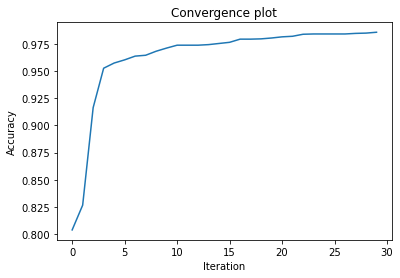

In [24]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

In [25]:
results.head()

,number,value,datetime_start,datetime_complete,duration,params_activation0,params_activation1,params_activation2,params_filters_0,params_filters_1,...,params_num_conv_layers,params_num_dense_layers,params_optimizer_name,params_strides0,params_strides1,params_strides2,params_units0,params_units1,params_units2,state
0,0,0.968254,2021-10-01 10:49:50.613611,2021-10-01 10:53:03.327610,0 days 00:03:12.713999,relu,tanh,NaN,64,16.0,...,2,1,RMSprop,1,1.0,NaN,129,NaN,NaN,COMPLETE
1,1,0.963757,2021-10-01 10:53:03.383610,2021-10-01 10:53:14.591611,0 days 00:00:11.208001,tanh,tanh,NaN,16,NaN,...,1,2,Adam,2,NaN,NaN,356,374.0,NaN,COMPLETE
2,2,0.952645,2021-10-01 10:53:14.632610,2021-10-01 10:53:27.248611,0 days 00:00:12.616001,tanh,relu,tanh,16,32.0,...,2,3,Adam,2,2.0,NaN,446,113.0,255.0,COMPLETE
3,3,0.826720,2021-10-01 10:53:27.293611,2021-10-01 10:53:40.611611,0 days 00:00:13.318000,relu,NaN,NaN,32,NaN,...,1,1,RMSprop,2,NaN,NaN,283,NaN,NaN,COMPLETE
4,4,0.964550,2021-10-01 10:53:40.653610,2021-10-01 10:54:45.909611,0 days 00:01:05.256001,tanh,relu,NaN,16,16.0,...,2,2,Adam,1,1.0,NaN,50,413.0,NaN,COMPLETE


## Evaluate the model

In [26]:
# load best model

model = load_model(path_best_model)

In [27]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 28, 32)        51232     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 248)               1555704   
_________________________________________________________________
dense_77 (Dense)             (None, 10)                2490      
Total params: 1,611,090
Trainable params: 1,611,090
Non-trainable params: 0
___________________________________________

In [28]:
# make predictions in test set
result = model.evaluate(x=X_test, y=y_test)

132/132 [==============================] - 7s 52ms/step - loss: 0.0434 - accuracy: 0.9869


In [29]:
# print evaluation metrics
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.04338512942194939
accuracy 0.9869047403335571


## Confusion matrix

In [30]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[418,   0,   0,   0,   1,   0,   2,   0,   1,   0],
       [  0, 471,   0,   0,   0,   0,   1,   0,   1,   0],
       [  1,   2, 403,   1,   0,   0,   1,   0,   1,   0],
       [  0,   0,   1, 421,   0,   2,   0,   1,   0,   1],
       [  1,   2,   0,   0, 423,   0,   2,   1,   0,   0],
       [  0,   0,   0,   1,   0, 377,   2,   0,   2,   0],
       [  0,   0,   0,   0,   3,   0, 409,   0,   0,   0],
       [  0,   2,   1,   0,   0,   1,   0, 464,   0,   1],
       [  0,   3,   0,   0,   1,   0,   4,   0, 375,   1],
       [  2,   1,   0,   0,   6,   0,   0,   0,   1, 384]], dtype=int64)

Text(0.5, 13.421126458070283, 'Predicted label')

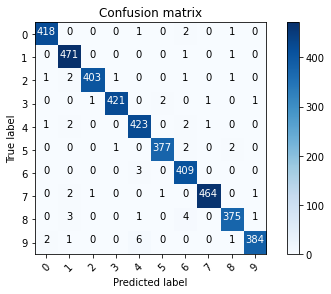

In [31]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

The model performed very well on all digits.

## Search Analysis

C:\Users\Elyas\AppData\Local\Temp/ipykernel_19804/2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


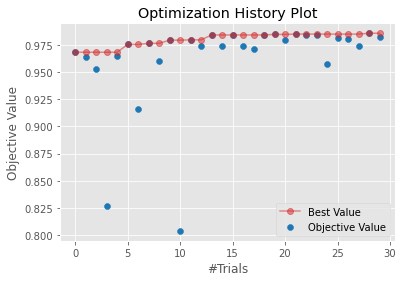

In [32]:
# Optimzation history
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\Elyas\AppData\Local\Temp/ipykernel_19804/1086962217.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


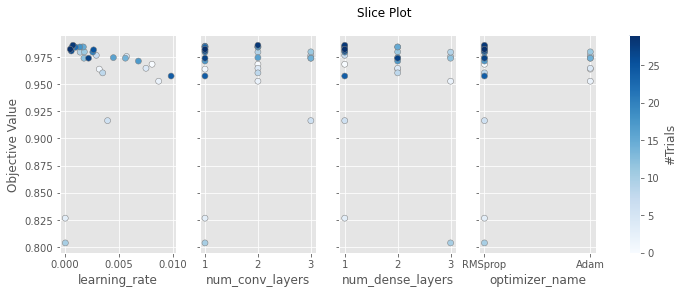

In [39]:
# Slice plots
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["num_conv_layers", "num_dense_layers", "optimizer_name", "learning_rate"],
    );

C:\Users\Elyas\AppData\Local\Temp/ipykernel_19804/2474202550.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study);


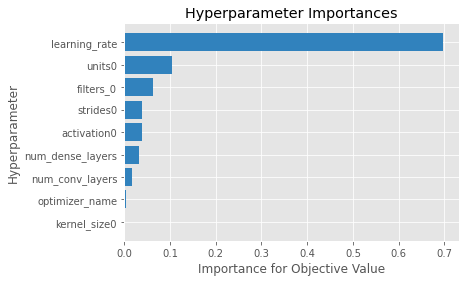

In [40]:
# Parameter importance
optuna.visualization.matplotlib.plot_param_importances(study);